# Library

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
import GA
%matplotlib inline

# Function

In [47]:
def initial_pop_digit(pop_size=10,n_genotype=3,first_num=0,final_num=100):
    data = np.arange(first_num,final_num)
    all_pop = np.random.choice(data,(pop_size, n_genotype))
    return all_pop

In [48]:
def fitness_pso(current_po):
    fitness = []
    for x in current_po:
        f = (x[0]**2+x[1]-11)**2+(x[0]+x[1]**2-7)**2
        fitness.append(f)
    fitness = np.array(fitness)
    return fitness

In [49]:
def position_group_Best(position,fitness):
    idx = np.argsort(fitness)
    fitness = fitness[idx]
    position = position[idx]
    return fitness,position

In [50]:
def velocity_new(current_po,v_old,pBest,gBest,W,c1,c2):
    v_dg_new = []
    for i in range(0,len(current_po)):
        v_dg_1 = W*v_old[i]+c1*np.random.rand()*(pBest[i]-current_po[i])+c2*np.random.rand()*(gBest-current_po[i])
        v_dg_new.append(v_dg_1)
    v_dg_new = np.array(v_dg_new)
    return v_dg_new

In [51]:
#Compare for find pBest
def PBEST_GBEST(current_po,fitness,new_po,update_fitness):
    pBest = []
    fitness_pBest = []
    for j in range(0,len(current_po)):
        if fitness[j]<update_fitness[j]:
            pBest.append(current_po[j])
            fitness_pBest.append(fitness[j])
        else:
            pBest.append(new_po[j])
            fitness_pBest.append(update_fitness[j])
    pBest = np.array(pBest)
    idx = np.argsort(fitness_pBest)
    fitness_p = fitness_pBest[idx[0]]
    gBest = pBest[idx[0]]
    return pBest,fitness_p,gBest

In [52]:
def set_measure_paramter(df_major):
    original_mean = np.array(np.mean(df_major[df_major.columns[0:]]))
    original_variance = np.array(np.std(df_major[df_major.columns[0:]]))
    ori_median = []
    for l in df_major.columns[:]:
        ori_median.append(np.array(np.median(df_major[l])))
    original_median = np.array(ori_median)
    
    return original_mean,original_median,original_variance

In [53]:
def fitness_pso_undersam(pop_dg,pop_s,df_major,original_mean,original_median,original_variance,size_df_minor): #1*-1 dimension
    #pop_s is pop_s
    #pop_dg is pop_dg
    g_new_pop_s = []
    fitness_new_pop_s = []

    for p in pop_dg:
        idx = np.argsort(p) #sort small to big
        new_pop_s = pop_s[idx]
        g_new_pop_s.append(new_pop_s)
        
        #Evaluation fitness
        each_table =df_major.iloc[new_pop_s[0:size_df_minor]]
        
        MMV = set_measure_paramter(each_table) # Calculate mean median and variance 
        '''
        print("Size of Table = \n",len(each_table))
        print(each_table)
        print("Population of digit = {} \n mean = {} \n median = {} \n variance = {} ".format(p,MMV[0],MMV[1],MMV[2]))
        print("\n")
        '''
        
        obj_each_column = (MMV[0]/original_mean-1)**2+((MMV[1]+1)/(original_median+1)-1)**2+(MMV[2]/original_variance-1)**2
        each_fitness = np.sum(obj_each_column)
        fitness_new_pop_s.append(each_fitness)
        #print(each_fitness)
        #print("obj of each columns = \n",obj_each_column)
        #print("each fitness = ",each_fitness)
        
    fitness_new_pop_s = np.array(fitness_new_pop_s)
    #print(fitness_new_pop_s)
    g_new_pop_s = np.array(g_new_pop_s)
    
    return pop_dg,g_new_pop_s,fitness_new_pop_s

# Input Data

In [54]:
df = pd.read_excel("data_8000_203.xlsx")

In [55]:
Exited1 = []
Exited0 = []
for index,data in enumerate(df['Exited']):
    if data == 1:
        Exited1.append(index)
    else:
        Exited0.append(index)
print("Size of Exited1 (Minor)",len(Exited1))
print("Size of Exited0 (Major)",len(Exited0))

Size of Exited1 (Minor) 203
Size of Exited0 (Major) 7963


In [56]:
df_major = df.iloc[Exited0]
df_minor = df.iloc[Exited1]

df_major = pd.DataFrame(df_major,columns=df.columns[2:])
df_minor = pd.DataFrame(df_minor,columns=df.columns[2:])

# Information of data

In [57]:
print(df_major.info())
print("\n")
print(df_minor.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7963 entries, 0 to 8165
Data columns (total 10 columns):
CreditScore        7963 non-null int64
Geography          7963 non-null int64
Gender             7963 non-null int64
Age                7963 non-null int64
Tenure             7963 non-null int64
Balance            7963 non-null float64
NumOfProdect       7963 non-null int64
HasCrCard          7963 non-null int64
IsActiveMember     7963 non-null int64
EstimatedSalary    7963 non-null float64
dtypes: float64(2), int64(8)
memory usage: 684.3 KB
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 203 entries, 24 to 8086
Data columns (total 10 columns):
CreditScore        203 non-null int64
Geography          203 non-null int64
Gender             203 non-null int64
Age                203 non-null int64
Tenure             203 non-null int64
Balance            203 non-null float64
NumOfProdect       203 non-null int64
HasCrCard          203 non-null int64
IsActiveMember     203 non-

In [58]:
df_major.head(5)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProdect,HasCrCard,IsActiveMember,EstimatedSalary
0,608,1,0,41,1,83807.86,1,0,1,112542.58
1,699,0,0,39,1,0.00,2,0,0,93826.63
2,850,1,0,43,2,125510.82,1,1,1,79084.10
3,822,0,1,50,7,0.00,2,1,1,10062.80
4,501,0,1,44,4,142051.07,2,0,1,74940.50


# Shape of data

In [59]:
print("shape of major data",df_major.shape)
print("shape of minor data",df_minor.shape)

shape of major data (7963, 10)
shape of minor data (203, 10)


# Set parameter of original data for calculate mean median std

In [60]:
stat_ori = set_measure_paramter(df_major) #Statistic of original data (mean, median, variance)
size_df_minor = len(df_minor)
print(stat_ori)

(array([6.51853196e+02, 6.84917745e-01, 5.72522918e-01, 3.74083888e+01,
       5.03327891e+00, 7.27452968e+04, 1.54426724e+00, 7.07145548e-01,
       5.54564862e-01, 9.97383918e+04]), array([6.530000e+02, 0.000000e+00, 1.000000e+00, 3.600000e+01,
       5.000000e+00, 9.207268e+04, 2.000000e+00, 1.000000e+00,
       1.000000e+00, 9.964504e+04]), array([9.56478307e+01, 8.00952170e-01, 4.94712468e-01, 1.01247271e+01,
       2.88047686e+00, 6.28440943e+04, 5.09503529e-01, 4.55072216e-01,
       4.97013758e-01, 5.74019823e+04]))


# Workspace

## 1. Parameter of PSO

In [119]:
m = len(df_major)      #Number of variables
n = 20     #Population Size
Wmax = 0.8 #Inertia weight MAX
Wmin = 0.4 #Inertia weight MIN
c1 = 0.1   #Acceleration Factor
c2 = 0.1
max_iter = 5000 #maximum iteration
po_s = GA.pop_standard(len(df_major))
k=0
z = 0
Gbest_fit =[]
Gbest = []
Pbest = []
All_po = []

# STEP 1. Iniatialization

In [120]:
#Initial Population
po_dg = initial_pop_digit(n,m,first_num=0,final_num=10000)
#Initial Velocity
v_dg = 0.1*po_dg #Can use 0.1 factor
#Current Position
current_po = po_dg+v_dg
fitness = fitness_pso_undersam(current_po,po_s,df_major,stat_ori[0],stat_ori[1],stat_ori[2],size_df_minor)[2]

# STEP 2. Evaluate Fitness

In [121]:
#Calculate fitness of each partical
#fitness = fitness_pso(current_po)
#Find Global best position
gBest = position_group_Best(current_po,fitness)[1][0]
gBest_fit = position_group_Best(current_po,fitness)[0][0]
#Initia pBest is current position
pBest = current_po 
v_old = v_dg

In [122]:
Gbest_fit.append(gBest_fit)
Gbest.append(gBest)
Pbest.append(pBest)
All_po.append(current_po)
print("iteration : {} Fitness: {:.10f} gBest_popsition: {}\n".format(0,gBest_fit,gBest))

iteration : 0 Fitness: 0.0189846582 gBest_popsition: [ 8950.7  9419.3 10121.1 ...  4682.7  1171.5  3316.5]



# Loop

iteration :1 [Fitness: 0.0097374]
iteration :2 [Fitness: 0.0097374]
iteration :3 [Fitness: 0.0097374]
iteration :4 [Fitness: 0.0097374]
iteration :5 [Fitness: 0.0097374]
iteration :6 [Fitness: 0.0097374]
iteration :7 [Fitness: 0.0097374]
iteration :8 [Fitness: 0.0077270]
iteration :9 [Fitness: 0.0045007]
iteration :10 [Fitness: 0.0045007]
iteration :11 [Fitness: 0.0045007]
iteration :12 [Fitness: 0.0045007]
iteration :13 [Fitness: 0.0045007]
iteration :14 [Fitness: 0.0045007]
iteration :15 [Fitness: 0.0045007]
iteration :16 [Fitness: 0.0045007]
iteration :17 [Fitness: 0.0045007]
iteration :18 [Fitness: 0.0045007]
iteration :19 [Fitness: 0.0045007]
iteration :20 [Fitness: 0.0045007]
iteration :21 [Fitness: 0.0045007]
iteration :22 [Fitness: 0.0043933]
iteration :23 [Fitness: 0.0043933]
iteration :24 [Fitness: 0.0043933]
iteration :25 [Fitness: 0.0043933]
iteration :26 [Fitness: 0.0043933]
iteration :27 [Fitness: 0.0042975]
iteration :28 [Fitness: 0.0042975]
iteration :29 [Fitness: 0.004

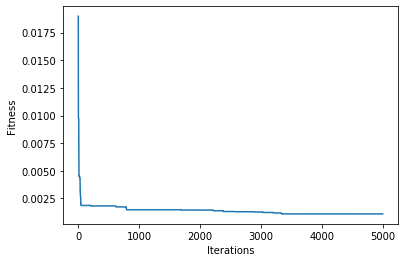

[ 7141.92322445  6320.82864912  5141.81861081 ... 10709.37100557
  1531.77978726  7831.18845056]
0.001099570776636116


In [123]:
start_time = time.time()
while z<max_iter:
    z += 1
    v_new = velocity_new(current_po,v_old,pBest,gBest,Wmax,c1,c2)
    fitness = fitness_pso_undersam(current_po,po_s,df_major,stat_ori[0],stat_ori[1],stat_ori[2],size_df_minor)[2]
    update_po = current_po+v_new
    update_fitness = fitness_pso_undersam(update_po,po_s,df_major,stat_ori[0],stat_ori[1],stat_ori[2],size_df_minor)[2]
    #print(update_fitness)
    if z>=2:
        fitness_pBest = fitness_pso_undersam(pBest,po_s,df_major,stat_ori[0],stat_ori[1],stat_ori[2],size_df_minor)[2]
        pBest = PBEST_GBEST(pBest,fitness_pBest,update_po,update_fitness)[0]
        gBest = PBEST_GBEST(pBest,fitness_pBest,update_po,update_fitness)[2]
        gBest_fit = PBEST_GBEST(pBest,fitness_pBest,update_po,update_fitness)[1]
    else:
        pBest = PBEST_GBEST(current_po,fitness,update_po,update_fitness)[0]
        gBest = PBEST_GBEST(current_po,fitness,update_po,update_fitness)[2]
        gBest_fit = PBEST_GBEST(current_po,fitness,update_po,update_fitness)[1]
        
    print("iteration :{} [Fitness: {:.7f}]".format(z,gBest_fit))
    
    Gbest_fit.append(gBest_fit)
    Gbest.append(gBest)
    Pbest.append(pBest)
    All_po.append(update_po)
    #Update position and velocity for next iteration
    current_po = update_po
    v_old = v_new
    '''
    if z>=2:
        if Gbest_fit[-1]==Gbest_fit[-2]:
            k+=1
            if k==200:
                print("k:",k)
                final_cross_pop = GA.crossover(current_po,1,m,n)
                final_mutate_pop = GA.mutattion(final_cross_pop,1,m,n,0,len(df_major),100) 
                current_po = final_mutate_pop
                #v_old = initial_pop_digit(n,n_genotype=m,first_num=0,final_num=1)
                k=0
        else:
            k=0
    '''
    if z>=2:
        if Gbest_fit[-1]==Gbest_fit[-2]:
            k+=1
            if k==100:
                print("k:",k)
                current_po = initial_pop_digit(n,m,first_num=0,final_num=10000)
                #Initial Velocity
                v_old = 0.1*current_po #Can use 0.1 factor
                #Current Position
                current_po = current_po+v_old
                k=0
        else:
            k=0
            

current_time = time.time()
elapsed_time = current_time - start_time

print("Total Time for PSO = {:.3f} minutes or {:.3f} second".format(elapsed_time/60,elapsed_time))
plt.clf()
xticks = range(1, len(Gbest_fit)+1)
plt.plot(xticks, Gbest_fit)
plt.xlabel('Iterations')
plt.ylabel('Fitness')
plt.pause(1e-10)
plt.show()

dex = np.argsort(Gbest_fit)
pop_best = Gbest[dex[0]]

print(pop_best)
print(Gbest_fit[dex[0]])

In [124]:
All_po[-1]

array([[ 7141.92322445,  6320.82864912,  5141.81861081, ...,
        10709.37100557,  1531.77978726,  7831.18845056],
       [ 7141.98061365,  6320.86641499,  5141.77929201, ...,
        10709.544297  ,  1531.68034321,  7831.24485116],
       [ 7137.32198594,  6317.94326301,  5145.11644594, ...,
        10695.50073691,  1539.96959295,  7826.64357834],
       ...,
       [ 7141.92313323,  6320.82855582,  5141.81881759, ...,
        10709.37068327,  1531.77971774,  7831.18821841],
       [ 7141.93748689,  6320.83775534,  5141.80904832, ...,
        10709.41302411,  1531.75583425,  7831.2027057 ],
       [ 7139.48807097,  6319.27155677,  5143.47593238, ...,
        10702.13291256,  1536.01688854,  7828.76897397]])

In [125]:
dd = np.argsort(pop_best)
final_po = po_s[dd]
final_table =df_major.iloc[final_po[0:size_df_minor]]
str_fitness = str(Gbest_fit[dex[0]])[0:7]
str_time = str(elapsed_time)[0:5]+"sec"

In [126]:
final_table

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProdect,HasCrCard,IsActiveMember,EstimatedSalary
7941,586,2,1,38,2,136858.42,1,0,1,189143.94
3981,735,0,1,41,7,179904.00,1,1,1,137180.95
5926,653,0,0,74,0,121276.32,1,1,1,160348.31
6048,622,0,1,29,7,101486.96,1,1,1,8788.35
5451,662,0,0,39,5,138106.75,1,0,0,19596.73
...,...,...,...,...,...,...,...,...,...,...
6384,557,0,0,27,3,87739.08,1,1,1,123096.56
2389,734,1,0,37,0,152760.24,1,1,1,48990.50
3563,845,1,0,38,2,112803.92,1,1,0,179631.85
4168,479,1,1,37,6,118433.94,1,0,1,160060.90


In [127]:
stat_ori[0]/set_measure_paramter(final_table)[0]

array([1.00086376, 1.00027556, 1.00191511, 0.99435681, 1.01667226,
       1.00589923, 0.99519444, 1.00384997, 1.00514881, 0.98711575])

In [128]:
stat_ori

(array([6.51853196e+02, 6.84917745e-01, 5.72522918e-01, 3.74083888e+01,
        5.03327891e+00, 7.27452968e+04, 1.54426724e+00, 7.07145548e-01,
        5.54564862e-01, 9.97383918e+04]),
 array([6.530000e+02, 0.000000e+00, 1.000000e+00, 3.600000e+01,
        5.000000e+00, 9.207268e+04, 2.000000e+00, 1.000000e+00,
        1.000000e+00, 9.964504e+04]),
 array([9.56478307e+01, 8.00952170e-01, 4.94712468e-01, 1.01247271e+01,
        2.88047686e+00, 6.28440943e+04, 5.09503529e-01, 4.55072216e-01,
        4.97013758e-01, 5.74019823e+04]))

In [129]:
set_measure_paramter(final_table)

(array([6.51290640e+02, 6.84729064e-01, 5.71428571e-01, 3.76206897e+01,
        4.95073892e+00, 7.23186725e+04, 1.55172414e+00, 7.04433498e-01,
        5.51724138e-01, 1.01040219e+05]),
 array([6.5300000e+02, 0.0000000e+00, 1.0000000e+00, 3.6000000e+01,
        5.0000000e+00, 9.1538510e+04, 2.0000000e+00, 1.0000000e+00,
        1.0000000e+00, 1.0060173e+05]),
 array([9.58479875e+01, 7.93516400e-01, 4.94871659e-01, 1.02788206e+01,
        2.89173051e+00, 6.26737409e+04, 5.07126050e-01, 4.56296992e-01,
        4.97317417e-01, 5.76878469e+04]))

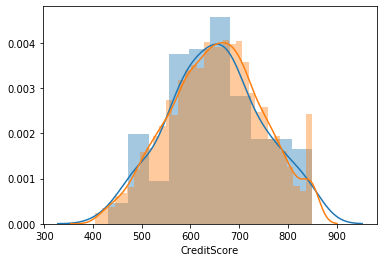

In [130]:
#best
sns.distplot(final_table[final_table.columns[0]])
#Orihinal
sns.distplot(df_major[df_major.columns[0]])

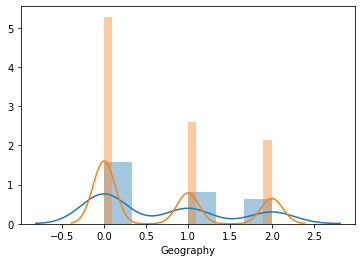

In [131]:
#best
sns.distplot(final_table[final_table.columns[1]])
#Orihinal
sns.distplot(df_major[df_major.columns[1]])

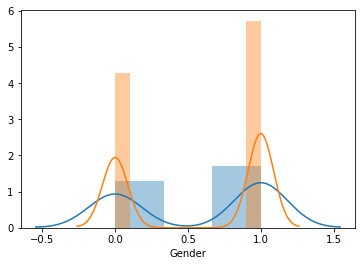

In [132]:
#best
sns.distplot(final_table[final_table.columns[2]])
#Orihinal
sns.distplot(df_major[df_major.columns[2]])

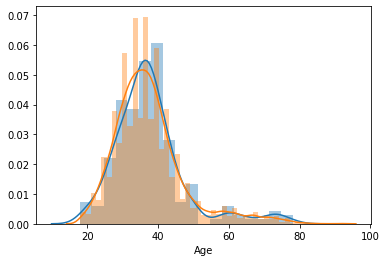

In [133]:
#best
sns.distplot(final_table[final_table.columns[3]])
#Orihinal
sns.distplot(df_major[df_major.columns[3]])

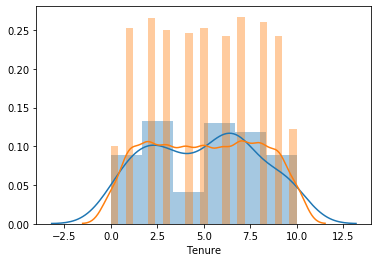

In [134]:
#best
sns.distplot(final_table[final_table.columns[4]])
#Orihinal
sns.distplot(df_major[df_major.columns[4]])

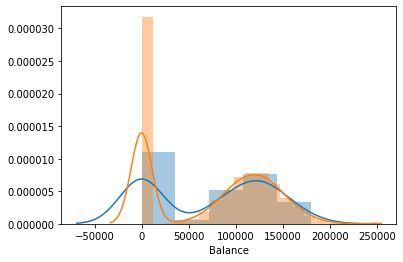

In [135]:
#best
sns.distplot(final_table[final_table.columns[5]])
#Orihinal
sns.distplot(df_major[df_major.columns[5]])

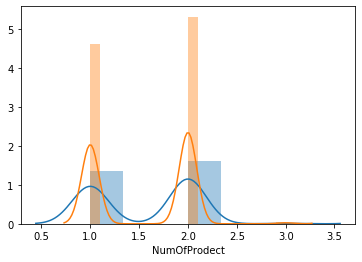

In [136]:
#best
sns.distplot(final_table[final_table.columns[6]])
#Orihinal
sns.distplot(df_major[df_major.columns[6]])

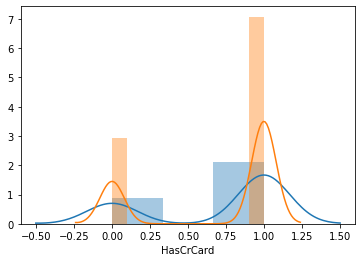

In [137]:
#best
sns.distplot(final_table[final_table.columns[7]])
#Orihinal
sns.distplot(df_major[df_major.columns[7]])

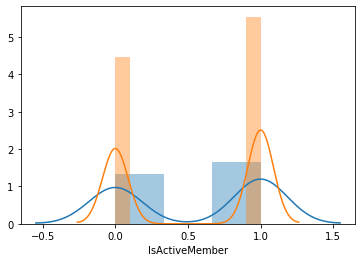

In [138]:
#best
sns.distplot(final_table[final_table.columns[8]])
#Orihinal
sns.distplot(df_major[df_major.columns[8]])

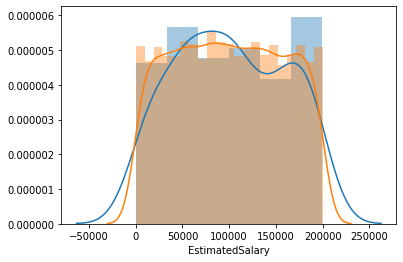

In [139]:
#best
sns.distplot(final_table[final_table.columns[9]])
#Orihinal
sns.distplot(df_major[df_major.columns[9]])

## 1.9 Combine new data with minority class

In [140]:
new_df_major = df.iloc[Exited0].iloc[final_po[0:size_df_minor]]

In [141]:
new_df_major

,Row no.,Exited,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProdect,HasCrCard,IsActiveMember,EstimatedSalary
7941,7942,0,586,2,1,38,2,136858.42,1,0,1,189143.94
3981,3982,0,735,0,1,41,7,179904.00,1,1,1,137180.95
5926,5927,0,653,0,0,74,0,121276.32,1,1,1,160348.31
6048,6049,0,622,0,1,29,7,101486.96,1,1,1,8788.35
5451,5452,0,662,0,0,39,5,138106.75,1,0,0,19596.73
...,...,...,...,...,...,...,...,...,...,...,...,...
6384,6385,0,557,0,0,27,3,87739.08,1,1,1,123096.56
2389,2390,0,734,1,0,37,0,152760.24,1,1,1,48990.50
3563,3564,0,845,1,0,38,2,112803.92,1,1,0,179631.85
4168,4169,0,479,1,1,37,6,118433.94,1,0,1,160060.90


In [142]:
DATA = np.vstack((new_df_major,df.iloc[Exited1]))

In [143]:
DATAnew = pd.DataFrame(DATA, columns=df.columns[0:])

In [144]:
DATAnew

,Row no.,Exited,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProdect,HasCrCard,IsActiveMember,EstimatedSalary
0,7942.0,0.0,586.0,2.0,1.0,38.0,2.0,136858.42,1.0,0.0,1.0,189143.94
1,3982.0,0.0,735.0,0.0,1.0,41.0,7.0,179904.00,1.0,1.0,1.0,137180.95
2,5927.0,0.0,653.0,0.0,0.0,74.0,0.0,121276.32,1.0,1.0,1.0,160348.31
3,6049.0,0.0,622.0,0.0,1.0,29.0,7.0,101486.96,1.0,1.0,1.0,8788.35
4,5452.0,0.0,662.0,0.0,0.0,39.0,5.0,138106.75,1.0,0.0,0.0,19596.73
...,...,...,...,...,...,...,...,...,...,...,...,...
401,7851.0,1.0,504.0,2.0,0.0,44.0,0.0,131873.07,2.0,1.0,1.0,158036.72
402,7934.0,1.0,710.0,1.0,1.0,62.0,3.0,131078.42,2.0,1.0,0.0,119348.76
403,7956.0,1.0,627.0,2.0,1.0,24.0,5.0,102773.20,2.0,1.0,0.0,56793.02
404,7975.0,1.0,520.0,0.0,1.0,49.0,5.0,121197.64,1.0,1.0,0.0,72577.33


## 2.0 Save Dataset to xlsx file

In [145]:
DATAnew.to_excel('406_resampling_under_objratio'+str_fitness+'time'+str_time+'.xlsx')

## 2.1 Save fitness of each iteration

In [146]:
# save numpy array as csv file
from numpy import asarray
from numpy import savetxt

# save to csv file
savetxt('data_fitness ratio'+str_fitness+'time'+str_time+'.csv', Gbest_fit, delimiter=',')

## 2.2 test load fitness file

# Test SVM

In [207]:
original_data = pd.read_excel("data_8000_203.xlsx")
new_data = pd.read_excel("406_resampling_under_objratio0.00087time734.1sec.xlsx")
original_data

,Row no.,Exited,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProdect,HasCrCard,IsActiveMember,EstimatedSalary
0,1,0,608,1,0,41,1,83807.86,1,0,1,112542.58
1,2,0,699,0,0,39,1,0.00,2,0,0,93826.63
2,3,0,850,1,0,43,2,125510.82,1,1,1,79084.10
3,4,0,822,0,1,50,7,0.00,2,1,1,10062.80
4,5,0,501,0,1,44,4,142051.07,2,0,1,74940.50
...,...,...,...,...,...,...,...,...,...,...,...,...
8161,8162,0,644,0,1,28,7,155060.41,1,1,0,29179.52
8162,8163,0,800,0,0,29,2,0.00,2,0,0,167773.55
8163,8164,0,771,0,1,39,5,0.00,2,1,0,96270.64
8164,8165,0,516,0,1,35,10,57369.61,1,1,1,101699.77


In [208]:
original_data.drop(['Row no.'], axis = 1 , inplace = True)
original_data

,Exited,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProdect,HasCrCard,IsActiveMember,EstimatedSalary
0,0,608,1,0,41,1,83807.86,1,0,1,112542.58
1,0,699,0,0,39,1,0.00,2,0,0,93826.63
2,0,850,1,0,43,2,125510.82,1,1,1,79084.10
3,0,822,0,1,50,7,0.00,2,1,1,10062.80
4,0,501,0,1,44,4,142051.07,2,0,1,74940.50
...,...,...,...,...,...,...,...,...,...,...,...
8161,0,644,0,1,28,7,155060.41,1,1,0,29179.52
8162,0,800,0,0,29,2,0.00,2,0,0,167773.55
8163,0,771,0,1,39,5,0.00,2,1,0,96270.64
8164,0,516,0,1,35,10,57369.61,1,1,1,101699.77


In [209]:
new_data = new_data[new_data.columns[0:]]
new_data.head()

,Unnamed: 0,Row no.,Exited,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProdect,HasCrCard,IsActiveMember,EstimatedSalary
0,0,4394,0,630,0,1,50,8,0.00,2,0,1,79377.45
1,1,2225,0,599,0,1,25,6,120383.41,1,1,1,24903.09
2,2,6172,0,797,2,0,33,10,83555.58,1,0,0,69767.14
3,3,2201,0,544,0,0,32,9,110728.39,1,1,1,14559.62
4,4,3744,0,778,0,1,37,3,141803.77,1,0,1,179421.84


In [210]:
new_data.drop(new_data.columns[[0,1]], axis = 1 , inplace = True) # axis = 0 remove row if axis = 1 remove column cut feature Patient Id
# inplace = True คือ ลบแบบถาวร

In [211]:
new_data

,Exited,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProdect,HasCrCard,IsActiveMember,EstimatedSalary
0,0,630,0,1,50,8,0.00,2,0,1,79377.45
1,0,599,0,1,25,6,120383.41,1,1,1,24903.09
2,0,797,2,0,33,10,83555.58,1,0,0,69767.14
3,0,544,0,0,32,9,110728.39,1,1,1,14559.62
4,0,778,0,1,37,3,141803.77,1,0,1,179421.84
...,...,...,...,...,...,...,...,...,...,...,...
401,1,504,2,0,44,0,131873.07,2,1,1,158036.72
402,1,710,1,1,62,3,131078.42,2,1,0,119348.76
403,1,627,2,1,24,5,102773.20,2,1,0,56793.02
404,1,520,0,1,49,5,121197.64,1,1,0,72577.33


In [212]:
x_ori = original_data.drop('Exited',axis = 1)
y_ori = original_data['Exited']
x_new = new_data.drop('Exited',axis = 1)
y_new = new_data['Exited']

In [213]:
from sklearn.model_selection import train_test_split
x_train_ori, x_test_ori, y_train_ori, y_test_ori = train_test_split(x_ori, y_ori, test_size = 0.20)
x_train_new, x_test_new, y_train_new, y_test_new = train_test_split(x_new, y_new, test_size = 0.2)

In [214]:
from sklearn.svm import SVC

In [215]:
svclassifier_ori = SVC(gamma='auto',kernel='sigmoid')
#svclassifier_ori = model(kernel='linear')
svclassifier_ori.fit(x_train_ori, y_train_ori)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='sigmoid',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [216]:
svclassifier_new = SVC(gamma='auto',kernel='sigmoid')
#svclassifier_new = model1(kernel='linear')
svclassifier_new.fit(x_train_new, y_train_new)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='sigmoid',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [217]:
y_pred_ori = svclassifier_ori.predict(x_test_ori)

In [218]:
y_pred_new = svclassifier_new.predict(x_test_new)

In [219]:
from sklearn.metrics import classification_report, confusion_matrix

In [220]:
print(confusion_matrix(y_test_ori,y_pred_ori))
print(classification_report(y_test_ori,y_pred_ori))

[[1602    0]
 [  32    0]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1602
           1       0.00      0.00      0.00        32

    accuracy                           0.98      1634
   macro avg       0.49      0.50      0.50      1634
weighted avg       0.96      0.98      0.97      1634



C:\Users\L\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [221]:
print(confusion_matrix(y_test_new,y_pred_new))
print(classification_report(y_test_new,y_pred_new))

[[ 0 43]
 [ 0 39]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        43
           1       0.48      1.00      0.64        39

    accuracy                           0.48        82
   macro avg       0.24      0.50      0.32        82
weighted avg       0.23      0.48      0.31        82



In [222]:
Class0 = pd.read_excel("class-0-churn-no-sur.xlsx")
Class1 = pd.read_excel("class-1-churn-no-sur.xlsx")

In [223]:
Class = np.vstack((Class0,Class1))

In [224]:
Class = pd.DataFrame(Class,columns=Class1.columns[:])

In [225]:
Class

,RowNumber,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,2.0,15647311.0,608.0,1.0,0.0,41.0,1.0,83807.86,1.0,0.0,1.0,112542.58,0.0
1,4.0,15701354.0,699.0,0.0,0.0,39.0,1.0,0.00,2.0,0.0,0.0,93826.63,0.0
2,5.0,15737888.0,850.0,1.0,0.0,43.0,2.0,125510.82,1.0,1.0,1.0,79084.10,0.0
3,7.0,15592531.0,822.0,0.0,1.0,50.0,7.0,0.00,2.0,1.0,1.0,10062.80,0.0
4,9.0,15792365.0,501.0,0.0,1.0,44.0,4.0,142051.07,2.0,0.0,1.0,74940.50,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9982.0,15672754.0,498.0,2.0,1.0,42.0,3.0,152039.70,1.0,1.0,1.0,53445.17,1.0
9996,9983.0,15768163.0,655.0,2.0,0.0,46.0,7.0,137145.12,1.0,1.0,0.0,115146.40,1.0
9997,9992.0,15769959.0,597.0,0.0,0.0,53.0,4.0,88381.21,1.0,1.0,0.0,69384.71,1.0
9998,9998.0,15584532.0,709.0,0.0,0.0,36.0,7.0,0.00,1.0,0.0,1.0,42085.58,1.0


In [231]:
XX_test = Class.drop(['Exited','RowNumber','CustomerId'],axis = 1)
YY_test = Class['Exited']

In [232]:
XX_test

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,608.0,1.0,0.0,41.0,1.0,83807.86,1.0,0.0,1.0,112542.58
1,699.0,0.0,0.0,39.0,1.0,0.00,2.0,0.0,0.0,93826.63
2,850.0,1.0,0.0,43.0,2.0,125510.82,1.0,1.0,1.0,79084.10
3,822.0,0.0,1.0,50.0,7.0,0.00,2.0,1.0,1.0,10062.80
4,501.0,0.0,1.0,44.0,4.0,142051.07,2.0,0.0,1.0,74940.50
...,...,...,...,...,...,...,...,...,...,...
9995,498.0,2.0,1.0,42.0,3.0,152039.70,1.0,1.0,1.0,53445.17
9996,655.0,2.0,0.0,46.0,7.0,137145.12,1.0,1.0,0.0,115146.40
9997,597.0,0.0,0.0,53.0,4.0,88381.21,1.0,1.0,0.0,69384.71
9998,709.0,0.0,0.0,36.0,7.0,0.00,1.0,0.0,1.0,42085.58


In [233]:
y_pred_class = svclassifier_new.predict(XX_test)

In [234]:
print(confusion_matrix(YY_test,y_pred_class))
print(classification_report(YY_test,y_pred_class))

[[   0 7963]
 [   0 2037]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      7963
         1.0       0.20      1.00      0.34      2037

    accuracy                           0.20     10000
   macro avg       0.10      0.50      0.17     10000
weighted avg       0.04      0.20      0.07     10000



C:\Users\L\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
